# VQ-VAE training example

Demonstration of how to train the model specified in https://arxiv.org/abs/1711.00937

On Mac and Linux, simply execute each cell in turn.

In [1]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

/home/tone/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


# Download Cifar10 data
This requires a connection to the internet and will download ~160MB.


In [2]:
'''
data_path = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

local_data_dir = tempfile.mkdtemp()  # Change this as needed
tf.gfile.MakeDirs(local_data_dir)

url = urllib.request.urlopen(data_path)
archive = tarfile.open(fileobj=url, mode='r|gz') # read a .tar.gz stream
archive.extractall(local_data_dir)
url.close()
archive.close()
print('extracted data files to %s' % local_data_dir)
'''

local_data_dir = '.'


# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [3]:
'''
def unpickle(filename):
  with open(filename, 'rb') as fo:
    return cPickle.load(fo, encoding='latin1')
  
def reshape_flattened_image_batch(flat_image_batch):
  return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC

def combine_batches(batch_list):
  images = np.vstack([reshape_flattened_image_batch(batch['data'])
                      for batch in batch_list])
  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)
  return {'images': images, 'labels': labels}
  


train_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_%d' % i))
    for i in range(1,5)
])

valid_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir,
                          'cifar-10-batches-py/data_batch_5'))])

test_data_dict = combine_batches([
    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/test_batch'))])
'''

"\ndef unpickle(filename):\n  with open(filename, 'rb') as fo:\n    return cPickle.load(fo, encoding='latin1')\n  \ndef reshape_flattened_image_batch(flat_image_batch):\n  return flat_image_batch.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])  # convert from NCHW to NHWC\n\ndef combine_batches(batch_list):\n  images = np.vstack([reshape_flattened_image_batch(batch['data'])\n                      for batch in batch_list])\n  labels = np.vstack([np.array(batch['labels']) for batch in batch_list]).reshape(-1, 1)\n  return {'images': images, 'labels': labels}\n  \n\n\ntrain_data_dict = combine_batches([\n    unpickle(os.path.join(local_data_dir,\n                          'cifar-10-batches-py/data_batch_%d' % i))\n    for i in range(1,5)\n])\n\nvalid_data_dict = combine_batches([\n    unpickle(os.path.join(local_data_dir,\n                          'cifar-10-batches-py/data_batch_5'))])\n\ntest_data_dict = combine_batches([\n    unpickle(os.path.join(local_data_dir, 'cifar-10-batches-py/te

In [4]:
#train_data_dict['images'].shape

In [5]:
#train_data_dict['labels']

In [6]:
data = np.load('data.npy')
labels = np.load('labels.npy')

In [7]:
#data.shape

In [8]:
#labels = labels.reshape((2080, 1))

In [9]:
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [10]:
arr = np.arange(2080)
np.random.shuffle(arr)

data = data[arr, :, :, :] 
labels = labels[arr]

In [11]:
labels[:10]

array([1, 2, 2, 0, 3, 3, 3, 3, 2, 0], dtype=uint8)

In [12]:
train_data_dict = {'images': data[:1040,:,:,:], 'labels': labels[:1040]}
valid_data_dict = {'images': data[1040:1560,:,:,:], 'labels': labels[1040:1560]}
test_data_dict  = {'images': data[1560:,:,:,:], 'labels': labels[1560:]}

In [13]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [0.5, 0.5]"""
  images = data_dict['images']
  data_dict['images'] = (tf.cast(images, tf.float32) / 255.0) - 0.5
  return data_dict

data_variance = np.var(train_data_dict['images'] / 255.0)

# Encoder & Decoder Architecture


In [14]:
def residual_stack(h, num_hiddens, num_residual_layers, num_residual_hiddens):
  for i in range(num_residual_layers):
    h_i = tf.nn.relu(h)

    h_i = snt.Conv2D(
        output_channels=num_residual_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="res3x3_%d" % i)(h_i)
    h_i = tf.nn.relu(h_i)

    h_i = snt.Conv2D(
        output_channels=num_hiddens,
        kernel_shape=(1, 1),
        stride=(1, 1),
        name="res1x1_%d" % i)(h_i)
    h += h_i
  return tf.nn.relu(h)

class Encoder(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='encoder'):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    
  def _build(self, x):
    h = snt.Conv2D(
        output_channels=self._num_hiddens / 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")(x)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")(h)
    h = tf.nn.relu(h)

    h = snt.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")(h)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='decoder'):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
  
  def _build(self, x):
    h = snt.Conv2D(
      output_channels=self._num_hiddens,
      kernel_shape=(3, 3),
      stride=(1, 1),
      name="dec_1")(x)

    h = residual_stack(
        h,
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

    h = snt.Conv2DTranspose(
        output_channels=int(self._num_hiddens / 2),
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")(h)
    h = tf.nn.relu(h)

    x_recon = snt.Conv2DTranspose(
        output_channels=3,
        output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")(h)

    return x_recon


# Build Graph and train

In [15]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32
image_size = 128

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
num_training_updates = 5000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = False

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
valid_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)).make_initializable_iterator()
train_dataset_batch = train_dataset_iterator.get_next()
valid_dataset_batch = valid_dataset_iterator.get_next()

def get_images(sess, subset='train'):
  if subset == 'train':
    return sess.run(train_dataset_batch)['images']
  elif subset == 'valid':
    return sess.run(valid_dataset_batch)['images']


# Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
pre_vq_conv1 = snt.Conv2D(output_channels=embedding_dim,
    kernel_shape=(1, 1),
    stride=(1, 1),
    name="to_vq")

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, image_size, image_size, 3))
z = pre_vq_conv1(encoder(x))

# vq_output_train["quantize"] are the quantized outputs of the encoder.
# That is also what is used during training with the straight-through estimator. 
# To get the one-hot coded assignments use vq_output_train["encodings"] instead.
# These encodings will not pass gradients into to encoder, 
# but can be used to train a PixelCNN on top afterwards.

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_images(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 100 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()


/home/tone/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/tone/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/home/tone/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
100 iterations
recon_error: 0.736
perplexity: 2.625

200 iterations
recon_error: 0.401
perplexity: 3.190

300 iterations
recon_error: 0.297
perplexity: 3.617

400 iterations
recon_error: 0.256
perplexity: 4.190

500 iterations
recon_error: 0.252
perplexity: 4.199

600 iterations
recon_error: 0.172
perplexity: 5.284

700 iterations
recon_error: 0.216
perplexity: 3.651

800 iterations
recon_error: 0.189
perplexity: 3.678

900 iterations
recon_error: 0.172
perplexity: 4.301

1000 iterations
recon_error: 0.174
perplexity: 4.324

1100 iterations
recon_error: 0.209
perplexity: 5.922

1200 iterations
recon_error: 0.129
perplexity: 7.018

1300 iterations
recon_error: 0.099
perplexity: 5.935

1400 iterations
recon_error: 0.111
perplexity: 5.509

1500 iterations
recon_error: 0.132
perplexity: 5.397

1600 iterations
recon_error: 0.122
perplexity: 5.676

1700 iterations
recon_err

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

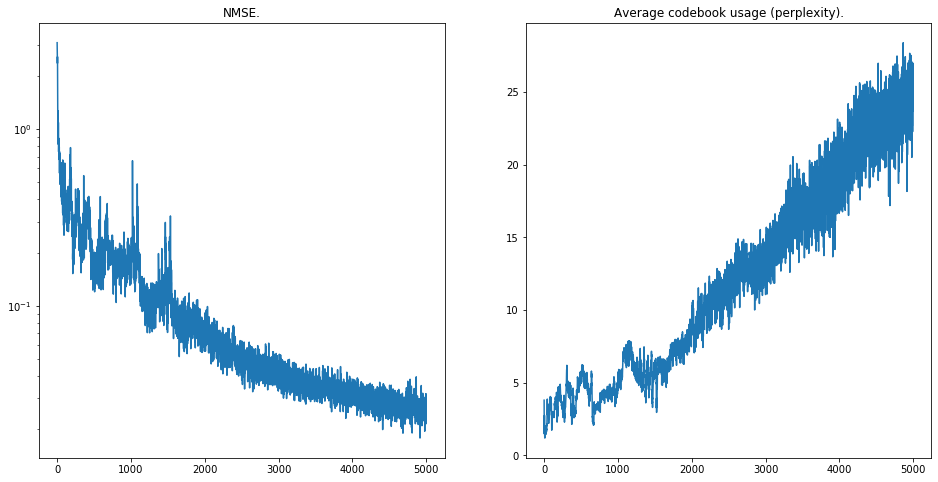

In [16]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')


# View reconstructions

(-0.5, 1023.5, 511.5, -0.5)

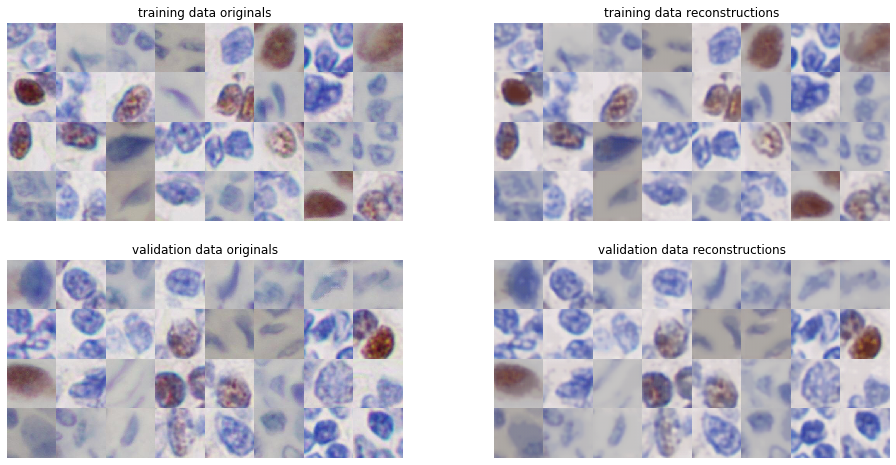

In [19]:
# Reconstructions
sess.run(valid_dataset_iterator.initializer)
train_originals = get_images(sess, subset='train')
train_reconstructions = sess.run(x_recon_eval, feed_dict={x: train_originals})
valid_originals = get_images(sess, subset='valid')
valid_reconstructions = sess.run(x_recon_eval, feed_dict={x: valid_originals})

def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 128, 128, 3)
              .transpose(0, 2, 1, 3, 4)
              .reshape(4 * 128, 8 * 128, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_originals),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_originals),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')
